# Deep Learning

## Assignment 3

Previously in 2_fullyconnected.ipynb, you trained a logistic regression and a neural network model.
The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

In [44]:
import matplotlib.pyplot as plt
import time
%matplotlib inline

First reload the data we generated in notmist.ipynb.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:

* data as a flat matrix,
* labels as float 1-hot encodings

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1)==  np.argmax(labels, 1))
            / predictions.shape[0])

***

## Problem 1

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor t using nn.l2_loss(t). The right amount of regularization should improve your validation / test accuracy.
***

First try it on logistics regression

In [21]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_beta = tf.placeholder(tf.float32)
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables
    weights = tf.Variable(
      tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + tf_beta * tf.nn.l2_loss(weights)
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
      tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [27]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, tf_beta: 1e-3}
        _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
              valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 16.468800
Minibatch accuracy: 10.9%
Validation accuracy: 15.2%
Minibatch loss at step 500: 3.216318
Minibatch accuracy: 77.3%
Validation accuracy: 76.6%
Minibatch loss at step 1000: 1.665687
Minibatch accuracy: 78.1%
Validation accuracy: 78.1%
Minibatch loss at step 1500: 1.272375
Minibatch accuracy: 85.2%
Validation accuracy: 80.2%
Minibatch loss at step 2000: 1.125988
Minibatch accuracy: 82.0%
Validation accuracy: 81.4%
Minibatch loss at step 2500: 0.921402
Minibatch accuracy: 78.9%
Validation accuracy: 81.6%
Minibatch loss at step 3000: 0.901254
Minibatch accuracy: 78.9%
Validation accuracy: 81.8%
Test accuracy: 88.6%


Now lets tune our hyperparameter beta
I would like to use only the validation set to determine which beta I will use.
In addition, I would also like to see how consisting my testset scores with my
validation scores

In [43]:
num_steps = 3001
betas = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
valid_scores = []
test_scores = []
np.random.seed(10)  # set seed

# start timer
time.clock()
for beta in betas:
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        for step in range(num_steps):
            # Lets use a better randomization across epochs
            idx = np.random.randint(low=0, high=train_labels.shape[0], size=batch_size)
            batch_data = train_dataset[idx, :]
            batch_labels = train_labels[idx, :]
            feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, tf_beta: beta}
            _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
#             if(step % 500 == 0):
#                 print("Minibatch loss at step %d: %f" %(step, l))
#                 print("Minibatch accuracy: %.1f%%" %accuracy(predictions, batch_labels))
#         print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
        valid_scores.append(accuracy(valid_prediction.eval(), valid_labels))
#         print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
        test_scores.append(accuracy(test_prediction.eval(), test_labels))
# total time
print("total time: " + str(time.clock()) + ' sec')

total time: 22710.981689 sec


<function matplotlib.pyplot.show>

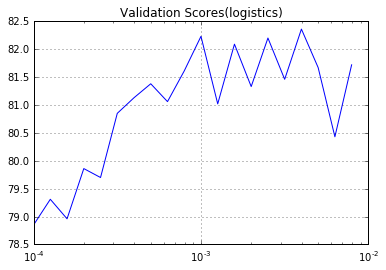

In [46]:
plt.semilogx(betas, valid_scores)
plt.grid(True)
plt.title("Validation Scores(logistics)")
plt.show

<function matplotlib.pyplot.show>

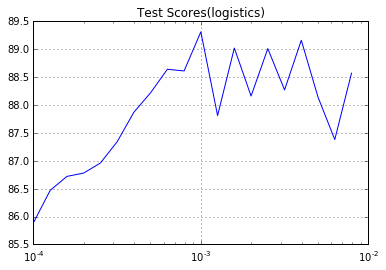

In [47]:
plt.semilogx(betas, test_scores)
plt.grid(True)
plt.title("Test Scores(logistics)")
plt.show

Intresting! vlidation socres is similar to test scores and both achieved a really high score when beta is 10^-3. However, it was a little bit ambiguious that validation score has the highest at 10^-2.4
***

Next let's try it on my very first neural network. Since 10^-3 gives me the highest score for logistics, I would love to see how well it performes on neural network

In [97]:
hidden_nodes = 1024
batch_size = 128

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_beta = tf.placeholder(tf.float32)
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Hidden layer
    hidden_weights = tf.Variable(
        tf.truncated_normal([image_size * image_size, hidden_nodes]))
    hidden_biases = tf.Variable(tf.zeros([hidden_nodes]))
    hidden1 = tf.nn.relu(tf.matmul(tf_train_dataset, hidden_weights) + hidden_biases)
    
    # Variables
    weights2 = tf.Variable(
      tf.truncated_normal([hidden_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
     
    # Training computation.
    logits = tf.matmul(hidden1, weights2) + biases2
    loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) \
    + tf_beta * (tf.nn.l2_loss(hidden_weights) + tf.nn.l2_loss(weights2))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_relu = tf.nn.relu(tf.matmul(tf_valid_dataset, hidden_weights) + hidden_biases)
    valid_prediction = tf.nn.softmax(
      tf.matmul(valid_relu, weights2) + biases2)
    test_relu = tf.nn.relu(tf.matmul(tf_test_dataset, hidden_weights) + hidden_biases)
    test_prediction = tf.nn.softmax(tf.matmul(test_relu, weights2) + biases2)

In [59]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    time.clock()
    print("Initialized")
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, tf_beta: 1e-3}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" %(step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    print("total time: " + str(time.clock()) + ' sec')

Initialized
Minibatch loss at step 0: 2875.524658
Minibatch accuracy: 10.9%
Validation accuracy: 22.4%
Minibatch loss at step 500: 46.595001
Minibatch accuracy: 78.1%
Validation accuracy: 84.7%
Minibatch loss at step 1000: 1.583724
Minibatch accuracy: 83.6%
Validation accuracy: 84.1%
Minibatch loss at step 1500: 0.660033
Minibatch accuracy: 85.2%
Validation accuracy: 84.6%
Minibatch loss at step 2000: 0.851509
Minibatch accuracy: 81.2%
Validation accuracy: 84.3%
Minibatch loss at step 2500: 0.737090
Minibatch accuracy: 82.0%
Validation accuracy: 83.8%
Minibatch loss at step 3000: 0.741408
Minibatch accuracy: 81.2%
Validation accuracy: 84.0%
Test accuracy: 90.3%
total time: 23593.092904 sec


Okay, a little bit better. Finally, achieve 90%. Let's tune beta again!

In [98]:
num_steps = 3001
betas = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
valid_scores = []
test_scores = []
best_beta = 0
max_valid = 0

# start time
# time.clock()
for beta in betas:
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        print("Initialized " + str(beta))
        for step in range(num_steps):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, tf_beta: beta}
            _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        valid_score = accuracy(valid_prediction.eval(), valid_labels)
        valid_scores.append(valid_score)
        if (valid_score > max_valid):
            best_beta = beta
            max_valid = valid_score
        test_scores.append(accuracy(test_prediction.eval(), test_labels))
# print("Total time: " + str(time.clock) + ' sec')

Initialized 0.0001
Initialized 0.000125892541179
Initialized 0.000158489319246
Initialized 0.000199526231497
Initialized 0.000251188643151
Initialized 0.000316227766017
Initialized 0.000398107170553
Initialized 0.000501187233627
Initialized 0.00063095734448
Initialized 0.000794328234724
Initialized 0.001
Initialized 0.00125892541179
Initialized 0.00158489319246
Initialized 0.00199526231497
Initialized 0.00251188643151
Initialized 0.00316227766017
Initialized 0.00398107170553
Initialized 0.00501187233627
Initialized 0.0063095734448
Initialized 0.00794328234724


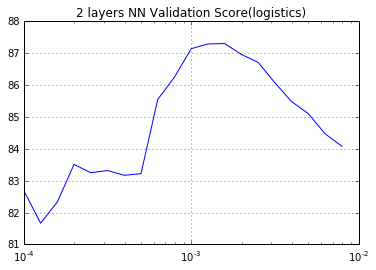

In [99]:
plt.semilogx(betas, valid_scores)
plt.grid(True)
plt.title("2 layers NN Validation Score(logistics)")
plt.show()

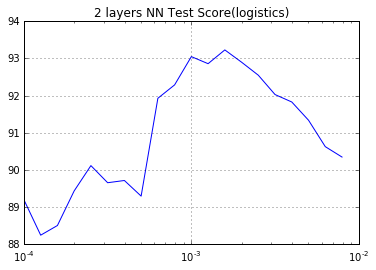

In [100]:
plt.semilogx(betas, test_scores)
plt.grid(True)
plt.title("2 layers NN Test Score(logistics)")
plt.show()

The validation set is identical to the test set so it is a good indicator for tuning the hyperparameter beta.

## Problem 2

Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

***

The following example restricts batches number to only 5. In addition, we will be choosing offset by step % num_batches(e.g. 0, 1, 2, 3, 4). Let's see how extreme the overfitting will be.

In [77]:
hidden_nodes = 1024
batch_size = 128

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_beta = tf.placeholder(tf.float32)
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Hidden layer
    hidden_weights = tf.Variable(
        tf.truncated_normal([image_size * image_size, hidden_nodes]))
    hidden_biases = tf.Variable(tf.zeros([hidden_nodes]))
    hidden1 = tf.nn.relu(tf.matmul(tf_train_dataset, hidden_weights) + hidden_biases)
    
    # Variables
    weights2 = tf.Variable(
      tf.truncated_normal([hidden_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
     
    # Training computation.
    logits = tf.matmul(hidden1, weights2) + biases2
    loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) \
    + tf_beta * (tf.nn.l2_loss(hidden_weights) + tf.nn.l2_loss(weights2))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_relu = tf.nn.relu(tf.matmul(tf_valid_dataset, hidden_weights) + hidden_biases)
    valid_prediction = tf.nn.softmax(
      tf.matmul(valid_relu, weights2) + biases2)
    test_relu = tf.nn.relu(tf.matmul(tf_test_dataset, hidden_weights) + hidden_biases)
    test_prediction = tf.nn.softmax(tf.matmul(test_relu, weights2) + biases2)

In [78]:
num_steps = 1000
num_batches = 3

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    time.clock()
    print("Initialized")
    for step in range(num_steps):
        offset = step % num_batches
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, tf_beta: 1e-3}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" %(step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    print("total time: " + str(time.clock()) + ' sec')

Initialized
Minibatch loss at step 0: 706.044739
Minibatch accuracy: 6.2%
Validation accuracy: 23.7%
Minibatch loss at step 500: 191.451172
Minibatch accuracy: 100.0%
Validation accuracy: 60.2%
Test accuracy: 65.8%
total time: 29061.846931 sec


From the above result, we can see the model is doing very well on the training dataset but it fails on the validation dataset and the test dataset because of overfitting.

***

## Problem 3

Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides nn.dropout() for that, but you have to make sure it's only inserted during training.
What happens to our extreme overfitting case?
***

In [75]:
hidden_nodes = 1024
batch_size = 128

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_beta = tf.placeholder(tf.float32)
    keep_prob = tf.placeholder(tf.float32)
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Hidden layer
    hidden_weights = tf.Variable(
        tf.truncated_normal([image_size * image_size, hidden_nodes]))
    hidden_biases = tf.Variable(tf.zeros([hidden_nodes]))
    hidden1 = tf.nn.relu(tf.matmul(tf_train_dataset, hidden_weights) + hidden_biases)
    
    # Variables
    weights2 = tf.Variable(
      tf.truncated_normal([hidden_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
     
    # Training computation.
    hidden1_drop = tf.nn.dropout(hidden1, keep_prob)
    logits = tf.matmul(hidden1_drop, weights2) + biases2
    loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) \
    + tf_beta * (tf.nn.l2_loss(hidden_weights) + tf.nn.l2_loss(weights2))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_relu = tf.nn.relu(tf.matmul(tf_valid_dataset, hidden_weights) + hidden_biases)
    valid_prediction = tf.nn.softmax(
      tf.matmul(valid_relu, weights2) + biases2)
    test_relu = tf.nn.relu(tf.matmul(tf_test_dataset, hidden_weights) + hidden_biases)
    test_prediction = tf.nn.softmax(tf.matmul(test_relu, weights2) + biases2)

In [76]:
num_steps = 1000
num_batches = 3

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    time.clock()
    print("Initialized")
    for step in range(num_steps):
        offset = step % num_batches
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, tf_beta: 1e-3,
                    keep_prob: 0.5}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" %(step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    print("total time: " + str(time.clock()) + ' sec')

Initialized
Minibatch loss at step 0: 847.693542
Minibatch accuracy: 11.7%
Validation accuracy: 28.4%
Minibatch loss at step 500: 191.396057
Minibatch accuracy: 100.0%
Validation accuracy: 66.4%
Test accuracy: 72.3%
total time: 28978.431858 sec


We have a little jump from 65.8% to 72.3% on the test dataset. Baes on the value 30 rule I can say that the result is significant better by applying dropout on the training dataset.

***

***

## Problem 4

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is 97.1%.

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:


* global_step = tf.Variable(0)  # count the number of steps taken.

  learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
  
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,       global_step=global_step)


First, I want to try a 3 layers neural network and see how much I can improve

In [94]:
batch_size = 128
num_hidden1_nodes = 1024
num_hidden2_nodes = 100

graph = tf.Graph()
with graph.as_default():

    # Initial training, validation, and testing
    tf_train_dataset = tf.placeholder(tf.float32, 
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    tf_beta = tf.placeholder(tf.float32)
    keep_prob = tf.placeholder(tf.float32)
    global_step = tf.Variable(0)  # count the number of steps taken

    # hidden layer 1
    # It is import to initial neurons with a slightly positive bias to avoid
    # "dead neurons"
    hidden1_weights = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_hidden1_nodes],
                           stddev = np.sqrt(2.0 / (image_size * image_size))))
    hidden1_biases = tf.Variable(tf.zeros([num_hidden1_nodes]))
    regu_hidden1 = tf.nn.l2_loss(hidden1_weights)

    # hidden layer 2
    hidden2_weights = tf.Variable(
        tf.truncated_normal([num_hidden1_nodes, num_hidden2_nodes],
                           stddev = np.sqrt(2.0 / num_hidden1_nodes)))
    hidden2_biases = tf.Variable(tf.zeros([num_hidden2_nodes]))
    regu_hidden2 = tf.nn.l2_loss(hidden2_weights)

    # output layer
    weights = tf.Variable(
        tf.truncated_normal([num_hidden2_nodes, num_labels],
                           stddev = np.sqrt(2.0 / num_hidden2_nodes)))
    biases = tf.Variable(tf.zeros([num_labels]))
    regu_weights = tf.nn.l2_loss(weights)

    # Training computation
    hidden1 = tf.nn.relu(tf.matmul(tf_train_dataset, hidden1_weights) + hidden1_biases)
#     hidden1_drop = tf.nn.dropout(hidden1, keep_prob)
    hidden2 = tf.nn.relu(tf.matmul(hidden1, hidden2_weights) + hidden2_biases)
    hidden2_drop = tf.nn.dropout(hidden2, keep_prob)
    logits = tf.matmul(hidden2_drop, weights) + biases
    loss = tf.reduce_mean(
          tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) \
        + tf_beta * (regu_hidden1 + regu_hidden2 + regu_weights)

    # Optimizer
    learning_rate = tf.train.exponential_decay(0.5, global_step, 5000, 0.65, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    # # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_h1 = tf.nn.relu(tf.matmul(tf_valid_dataset, hidden1_weights) + hidden1_biases)
    valid_h2 = tf.nn.relu(tf.matmul(valid_h1, hidden2_weights) + hidden2_biases)
    valid_prediction = tf.nn.softmax(
      tf.matmul(valid_h2, weights) + biases)
    test_h1 = tf.nn.relu(tf.matmul(tf_test_dataset, hidden1_weights) + hidden1_biases)
    test_h2 = tf.nn.relu(tf.matmul(test_h1, hidden2_weights) + hidden2_biases)
    test_prediction = tf.nn.softmax(tf.matmul(test_h2, weights) + biases)

In [96]:
num_steps = 19001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    time.clock()
    print("Initialized")
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, 
                     tf_beta: 1e-3, keep_prob: 0.5}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 1000 == 0):
            print("Minibatch loss at step %d: %f" %(step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    print("total time: " + str(time.clock()) + ' sec')

Initialized
Minibatch loss at step 0: 3.311022
Minibatch accuracy: 7.0%
Validation accuracy: 31.0%
Minibatch loss at step 1000: 0.855971
Minibatch accuracy: 85.9%
Validation accuracy: 85.8%
Minibatch loss at step 2000: 0.850621
Minibatch accuracy: 83.6%
Validation accuracy: 87.3%
Minibatch loss at step 3000: 0.630466
Minibatch accuracy: 86.7%
Validation accuracy: 87.9%
Minibatch loss at step 4000: 0.484113
Minibatch accuracy: 89.8%
Validation accuracy: 87.9%
Minibatch loss at step 5000: 0.570152
Minibatch accuracy: 87.5%
Validation accuracy: 88.2%
Minibatch loss at step 6000: 0.549380
Minibatch accuracy: 85.9%
Validation accuracy: 88.7%
Minibatch loss at step 7000: 0.449720
Minibatch accuracy: 90.6%
Validation accuracy: 88.8%
Minibatch loss at step 8000: 0.490355
Minibatch accuracy: 89.8%
Validation accuracy: 88.9%
Minibatch loss at step 9000: 0.557347
Minibatch accuracy: 86.7%
Validation accuracy: 89.3%
Minibatch loss at step 10000: 0.500347
Minibatch accuracy: 88.3%
Validation accura

Now, let's take a look at using three hidden layers

In [105]:
batch_size = 128
num_hidden1_nodes = 1024
num_hidden2_nodes = 256
num_hidden3_nodes = 50

graph = tf.Graph()
with graph.as_default():

    # Initial training, validation, and testing
    tf_train_dataset = tf.placeholder(tf.float32, 
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    tf_beta = tf.placeholder(tf.float32)
    keep_prob = tf.placeholder(tf.float32)
    global_step = tf.Variable(0)  # count the number of steps taken

    # hidden layer 1
    # It is import to initial neurons with a slightly positive bias to avoid
    # "dead neurons"
    hidden1_weights = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_hidden1_nodes],
                           stddev = np.sqrt(2.0 / (image_size * image_size))))
    hidden1_biases = tf.Variable(tf.zeros([num_hidden1_nodes]))
    regu_hidden1 = tf.nn.l2_loss(hidden1_weights)

    # hidden layer 2
    hidden2_weights = tf.Variable(
        tf.truncated_normal([num_hidden1_nodes, num_hidden2_nodes],
                           stddev = np.sqrt(2.0 / num_hidden1_nodes)))
    hidden2_biases = tf.Variable(tf.zeros([num_hidden2_nodes]))
    regu_hidden2 = tf.nn.l2_loss(hidden2_weights)
    
    # hidden layer 3
    hidden3_weights = tf.Variable(
        tf.truncated_normal([num_hidden2_nodes, num_hidden3_nodes],
                           stddev = np.sqrt(2.0 / num_hidden2_nodes)))
    hidden3_biases = tf.Variable(tf.zeros([num_hidden3_nodes]))
    regu_hidden3 = tf.nn.l2_loss(hidden3_weights)

    # output layer
    weights = tf.Variable(
        tf.truncated_normal([num_hidden3_nodes, num_labels],
                           stddev = np.sqrt(2.0 / num_hidden3_nodes)))
    biases = tf.Variable(tf.zeros([num_labels]))
    regu_weights = tf.nn.l2_loss(weights)

    # Training computation
    hidden1 = tf.nn.relu(tf.matmul(tf_train_dataset, hidden1_weights) + hidden1_biases)
#     hidden1_drop = tf.nn.dropout(hidden1, keep_prob)
    hidden2 = tf.nn.relu(tf.matmul(hidden1, hidden2_weights) + hidden2_biases)
#     hidden2_drop = tf.nn.dropout(hidden2, keep_prob)
    hidden3 = tf.nn.relu(tf.matmul(hidden2, hidden3_weights) + hidden3_biases)
    hidden3_drop = tf.nn.dropout(hidden3, keep_prob)
    logits = tf.matmul(hidden3_drop, weights) + biases
    loss = tf.reduce_mean(
          tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) \
        + tf_beta * (regu_hidden1 + regu_hidden2 + regu_hidden3 + regu_weights)

    # Optimizer
    learning_rate = tf.train.exponential_decay(0.5, global_step, 5000, 0.6, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    # # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_h1 = tf.nn.relu(tf.matmul(tf_valid_dataset, hidden1_weights) + hidden1_biases)
    valid_h2 = tf.nn.relu(tf.matmul(valid_h1, hidden2_weights) + hidden2_biases)
    valid_h3 = tf.nn.relu(tf.matmul(valid_h2, hidden3_weights) + hidden3_biases)
    valid_prediction = tf.nn.softmax(
      tf.matmul(valid_h3, weights) + biases)
    test_h1 = tf.nn.relu(tf.matmul(tf_test_dataset, hidden1_weights) + hidden1_biases)
    test_h2 = tf.nn.relu(tf.matmul(test_h1, hidden2_weights) + hidden2_biases)
    test_h3 = tf.nn.relu(tf.matmul(test_h2, hidden3_weights) + hidden3_biases)
    test_prediction = tf.nn.softmax(tf.matmul(test_h3, weights) + biases)

In [106]:
num_steps = 20001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    time.clock()
    print("Initialized")
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, 
                     tf_beta: 1e-3, keep_prob: 0.5}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 2000 == 0):
            print("Minibatch loss at step %d: %f" %(step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    print("total time: " + str(time.clock()) + ' sec')

Initialized
Minibatch loss at step 0: 3.490894
Minibatch accuracy: 10.2%
Validation accuracy: 21.6%
Minibatch loss at step 2000: 0.810998
Minibatch accuracy: 84.4%
Validation accuracy: 88.0%
Minibatch loss at step 4000: 0.512680
Minibatch accuracy: 89.1%
Validation accuracy: 87.2%
Minibatch loss at step 6000: 0.505532
Minibatch accuracy: 89.1%
Validation accuracy: 88.6%
Minibatch loss at step 8000: 0.542227
Minibatch accuracy: 92.2%
Validation accuracy: 89.3%
Minibatch loss at step 10000: 0.535631
Minibatch accuracy: 88.3%
Validation accuracy: 88.9%
Minibatch loss at step 12000: 0.391910
Minibatch accuracy: 93.0%
Validation accuracy: 89.8%
Minibatch loss at step 14000: 0.496230
Minibatch accuracy: 89.1%
Validation accuracy: 90.0%
Minibatch loss at step 16000: 0.371045
Minibatch accuracy: 93.8%
Validation accuracy: 90.7%
Minibatch loss at step 18000: 0.399157
Minibatch accuracy: 92.2%
Validation accuracy: 90.5%
Minibatch loss at step 20000: 0.399934
Minibatch accuracy: 93.0%
Validation 